In [1]:
#Improts 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sqlite3
import matplotlib.pyplot as plt
from mpl_chord_diagram import chord_diagram

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

path = "/workspaces/European-Soccer/Data/"  #Insert path here
database = path + "database.sqlite"

In [2]:
conn = sqlite3.connect(database)

tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [3]:
s = "2012/2013"
seasons = pd.read_sql(f"""SELECT DISTINCT season
                        FROM Match;""", conn).values.flatten().tolist()
Match = pd.read_sql(f"""SELECT 
                        league_id, season,
                        home_player_1, home_player_2, home_player_3, home_player_4, home_player_5, home_player_6, home_player_7, home_player_8, 
                        home_player_9, home_player_10, home_player_11, home_player_X1, home_player_X2, home_player_X3, 
                        home_player_X4, home_player_X5, home_player_X6, home_player_X7, home_player_X8, home_player_X9, 
                        home_player_X10, home_player_X11, home_player_Y1, home_player_Y2, home_player_Y3, home_player_Y4, 
                        home_player_Y5, home_player_Y6, home_player_Y7, home_player_Y8, home_player_Y9, home_player_Y10, 
                        home_player_Y11, 
                        away_player_1, away_player_2, away_player_3, away_player_4, away_player_5, away_player_6, away_player_7, away_player_8,
                        away_player_9, away_player_10, away_player_11, away_player_X1, away_player_X2, away_player_X3,
                        away_player_X4, away_player_X5, away_player_X6, away_player_X7, away_player_X8, away_player_X9,
                        away_player_X10, away_player_X11, away_player_Y1, away_player_Y2, away_player_Y3, away_player_Y4,
                        away_player_Y5, away_player_Y6, away_player_Y7, away_player_Y8, away_player_Y9, away_player_Y10,
                        away_player_Y11
                        FROM Match;""", conn).dropna()

League = pd.read_sql("""SELECT id, name
                        FROM League;""", conn)

In [23]:
Match.shape

(21361, 68)

In [5]:
seasons = list(Match.season.unique().astype(str))
seasons

['2008/2009',
 '2009/2010',
 '2010/2011',
 '2011/2012',
 '2012/2013',
 '2013/2014',
 '2014/2015',
 '2015/2016']

In [6]:
#create a table with all the players in a team in a season
def create_player_league_table(season):
    #select the season
    matches = Match.loc[Match["season"] == season, :]
    #melt the dataframes to have the play-league pair
    league_player = matches.melt(id_vars = ["league_id", "season"], \
                                            value_name="player_id", var_name="player").drop(['season', "player"], axis=1)

    #drop duplicated rows
    league_player = league_player.drop_duplicates('player_id').reset_index(drop=True)
    
    return league_player
    

In [7]:
create_player_league_table("2015/2016").head()

,league_id,player_id
0,1,242243.0
1,1,206592.0
2,1,91929.0
3,1,107806.0
4,1,37900.0


In [8]:
def next_season(season):
    assert seasons.count(season) != 0, "Season not found"
    assert seasons.index(season) < len(seasons)-1, "Last season"
    return seasons[list(seasons).index(season) + 1]

In [9]:
#create a transfer table
def compute_transfer(season):
    #create the player-league table for two consecutive seasons
    player_league_table1 = create_player_league_table(season)
    player_league_table2 = create_player_league_table(next_season(season))

    #find the players that are in the two seasons
    players = pd.merge(player_league_table1, player_league_table2, on="player_id", how="inner", suffixes=("_1", "_2"))

    #find the players that are in the two seasons and in the different league
    transfer = players.loc[players["league_id_1"] != players["league_id_2"], :].drop(["player_id"], axis=1).reset_index(drop=True)
    return transfer

In [10]:
compute_transfer("2014/2015").head()

,league_id_1,league_id_2
0,1,19694
1,1,21518
2,1729,10257
3,1729,13274
4,4769,21518


In [11]:
def transfer_matrix(season):

    transfer = compute_transfer(season)
    
    #create a transfer matrix
    matrix = pd.pivot_table(
        transfer, index=["league_id_1"], columns=["league_id_2"], aggfunc="size", fill_value=0
    )

    league_name = League.set_index("id")["name"].to_dict()
    names = [league_name[i] for i in matrix.columns]

    return matrix.values.tolist(), names

In [12]:
matrix, names = transfer_matrix("2014/2015")

In [13]:
pd.DataFrame(matrix)

,0,1,2,3,4,5,6,7,8,9,10
0,0,2,8,1,4,5,0,3,1,4,3
1,5,0,8,4,8,3,0,0,3,8,1
2,8,16,0,4,5,0,1,2,1,8,1
3,1,14,2,0,7,2,1,1,0,5,1
4,2,11,7,5,0,1,0,5,0,15,1
5,1,6,2,3,7,0,1,2,1,1,2
6,2,0,0,0,1,1,0,4,2,0,1
7,3,1,5,0,3,0,1,0,0,9,4
8,0,1,0,1,1,3,2,0,0,3,0
9,1,7,6,4,9,2,0,12,0,0,0


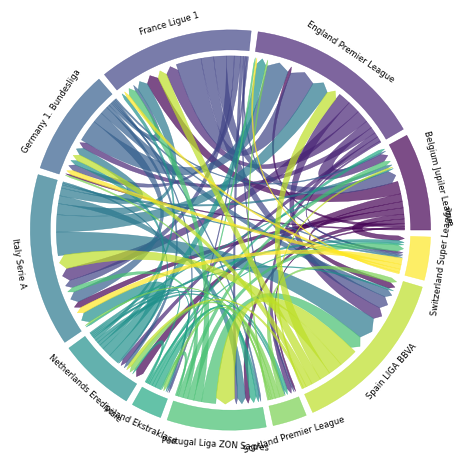

[(1.0182452528720838, 0.25627447200895065, -75.87306501547988),
 (0.5848221263620386, 0.8720568103726867, -33.846749226006196),
 (-0.29911359785826347, 1.006494438919702, 16.551083591331277),
 (-0.8754235057744005, 0.5797703731113363, 56.48452012383902),
 (-1.0369749430906976, -0.1648725792909312, -80.96594427244582),
 (-0.7107490022669581, -0.772875058322187, -42.602167182662555),
 (-0.4421802347914506, -0.9523532117653498, -24.905572755417978),
 (-0.07451770927235041, -1.0473524292256173, -4.0696594427245145),
 (0.3120594345605977, -1.0025561876033284, 17.28947368421052),
 (0.7906557095199191, -0.6909150085238801, 48.851393188854445),
 (1.039058519346197, -0.15118661770834266, 81.72136222910211)]

In [14]:
chord_diagram(matrix, names, gap=0.03, use_gradient=False, sort="size", directed=True,
                cmap=None, chord_colors=None, rotate_names=False, show = True, fontsize=6)

In [15]:
from google.cloud import bigquery

In [16]:
client = bigquery.Client()

In [20]:
query = r"""SELECT 
                            league_id, season,
                            home_player_1, home_player_2, home_player_3, home_player_4, home_player_5, home_player_6, home_player_7, home_player_8, 
                            home_player_9, home_player_10, home_player_11, home_player_X1, home_player_X2, home_player_X3, 
                            home_player_X4, home_player_X5, home_player_X6, home_player_X7, home_player_X8, home_player_X9, 
                            home_player_X10, home_player_X11, home_player_Y1, home_player_Y2, home_player_Y3, home_player_Y4, 
                            home_player_Y5, home_player_Y6, home_player_Y7, home_player_Y8, home_player_Y9, home_player_Y10, 
                            home_player_Y11, 
                            away_player_1, away_player_2, away_player_3, away_player_4, away_player_5, away_player_6, away_player_7, away_player_8,
                            away_player_9, away_player_10, away_player_11, away_player_X1, away_player_X2, away_player_X3,
                            away_player_X4, away_player_X5, away_player_X6, away_player_X7, away_player_X8, away_player_X9,
                            away_player_X10, away_player_X11, away_player_Y1, away_player_Y2, away_player_Y3, away_player_Y4,
                            away_player_Y5, away_player_Y6, away_player_Y7, away_player_Y8, away_player_Y9, away_player_Y10,
                            away_player_Y11
                            FROM mids-367807.european_soccer.Match;"""
query_job = client.query(query)
								
results = query_job.to_dataframe().dropna()# Waits for job to complete.

In [22]:
results.shape

(21360, 68)